In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import pySODE
import torchdiffeq

In [2]:
import ipyexperiments
import timeit
import time

In [3]:
torch.cuda.manual_seed_all(2)

## Defining linear ODE model

In [4]:
class GenericModel(object):
    def __init__(self, F, numpy=True):
        if numpy: self.F = F.numpy()
        else: self.F = F
        self.numpy = numpy
    def __call__(self, dt, x):
        if self.numpy: return np.matmul(self.F, x)
        else: return torch.matmul(self.F, x)

In [5]:
class SparseModel(GenericModel):
    def __init__(self, F, numpy=True):
        super().__init__(F, numpy)
    def __call__(self, dt, x):
        return self.F[0][0]*x

In [10]:
F_orig = -0.5*torch.eye(100000)
x_orig = 20*torch.rand(100000)
m = GenericModel(F_orig)

RuntimeError: [enforce fail at CPUAllocator.cpp:56] posix_memalign(&data, gAlignment, nbytes) == 0. 12 vs 0


# Benchmark 0: naive Euler as iterated GEMV

In [17]:
dt = 0.1
F = F_orig.cuda()
x0 = x_orig.cuda()

start = time.process_time()
for t in range(10):
    x0 += dt*(torch.matmul(F, x0))
elapsed_time = time.process_time() - start
print(elapsed_time)

0.0006520150000000058


# Benchmark 1: pySODE vs scipy.integrate.solve_ivp

Benchmark uses single step in ODEs --> higher overhead for CUDA kernel relaunching

In [20]:
exp1 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1060 3GB (3011 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   2,133   8,674  15,960 MB  13.37% 
GPU:   1,264   1,747   3,011 MB  41.97% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.000
･ CPU:          0          0      2,133 MB |
･ GPU:          0          0      1,264 MB |


### scipy (no knowledge of sparsity)

In [21]:
x0 = x_orig.numpy()
t = torch.linspace(0, 0.01)

start = time.process_time()
for i in range(10):
    x0 = scipy.integrate.solve_ivp(m, t, x0)
    x0 = [el[-1] for el in x0.y]
elapsed_time = time.process_time() - start
print(elapsed_time)

0.005688022999999376
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.006
･ CPU:          0          0      2,134 MB |
･ GPU:          0          0      1,264 MB |


### smart scipy (model encodes sparsity to save compute)

In [24]:
F_orig = -0.5*torch.eye(1000)
x_orig = 20*torch.rand(1000)
m = SparseModel(F_orig)

In [9]:
x0 = x_orig.numpy()
F = F_orig.cuda()
t = torch.linspace(0, 0.01)

start = time.process_time()
for i in range(10):
    x0 = scipy.integrate.solve_ivp(m, t, x0)
    x0 = [el[-1] for el in x0.y]
elapsed_time = time.process_time() - start
print(elapsed_time)

0.3715763589999881
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.341
･ CPU:          0          8      2,346 MB |
･ GPU:        382          0      1,610 MB |


### pySODE

In [7]:
dt = 0.1
F = F_orig.cuda()
x0 = x_orig.cuda()

start = time.process_time()
for t in range(10):
    x0 = pySODE.ode_solve(F, x0, x0, dt, 1, 10000, 'Euler')
elapsed_time = time.process_time() - start
print(elapsed_time)

0.00018074400000056556


In [20]:
print(f"pySODE (Euler) takes {round(100*(127.6201-0.0002200)/127.6201,4)}% less time (vs base scipy)")
print(f"pySODE (Euler) takes {round(100*(10.3715-0.0002200)/10.3715,4)}% less time (vs smart scipy)")
print(f"pySODE (Euler) takes {round(100*(0.01973-0.0002200)/0.01973,4)}% less time (vs smart torchdiffeq)")
print(f"pySODE (Euler) takes {round(100*(0.00053729-0.0002200)/0.00053729,4)}% less time (vs standard PyTorch GEMV)")

pySODE (Euler) takes 99.9998% less time (vs base scipy)
pySODE (Euler) takes 99.9979% less time (vs smart scipy)
pySODE (Euler) takes 98.8849% less time (vs smart torchdiffeq)
pySODE (Euler) takes 59.0538% less time (vs standard PyTorch GEMV)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.001
･ CPU:          0          0      2,517 MB |
･ GPU:          0          0      1,646 MB |


In [20]:
del exp1

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.000
･ CPU:          0          0      2,344 MB |
･ GPU:          0          0      1,215 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:04:00 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:        8        0 MB (  0.00%)
GPU:       -7        0 MB ( -0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   2,344   8,695  15,960 MB  14.69% 
GPU:   1,215   1,796   3,011 MB  40.35% 




# Benchmark 2: pySODE vs torchdiffeq.odeint

In [25]:
exp2 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1060 3GB (3011 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   2,466   8,535  15,960 MB  15.45% 
GPU:   1,604   1,407   3,011 MB  53.27% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.063
･ CPU:          0          0      2,466 MB |
･ GPU:          0          0      1,604 MB |
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.025
･ CPU:          0          0      2,466 MB |
･ GPU:          0          0      1,604 MB |


In [11]:
F_orig = F_orig.cuda()
x0 = x_orig.cuda()
m = SparseModel(F_orig, False)

In [12]:
t = torch.linspace(0, 0.1, 10)
x0 = x_orig.cuda()

start = time.process_time()
for i in range(1):
    x0 = torchdiffeq.odeint(m, x0, t, method='euler')
elapsed_time = time.process_time() - start
print(elapsed_time)

0.003048313999999941


In [16]:
del exp2

NameError: name 'exp2' is not defined

# Benchmark 3: pySODE vs scipy.integrate (SSRK4)

# Benchmark 4: pySODE vs torchdiffeq.odeint (SSRK4)

# Benchmark Final: training big MLP - pySODE vs torchdiffeq

# Plots

In [8]:
psize = [10, 100, 1000, 10000, 100000]
pysode_euler = [0.000181, 0.000188, 0.000180, 0.000181]
pysode_rk4 = []
pysode_euler_ss = []
pysode_euler_rk4 = []
torchdiffeq_euler = [0.003845, 0.002750, 0.003887, 0.003048]
GEMV = [0.000512, 0.000603, 0.002079, 0.000523]

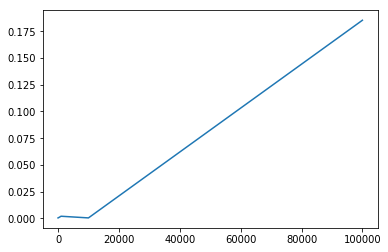

In [14]:
plt.plot(psize, GEMV)